In [6]:
import os, sys, pandas as pd, geopandas as gd
import datetime, glob, operator
import matplotlib.pyplot as plt
import seaborn as sns, simplejson as json
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import operator

In [221]:
def find_keys(key_list, regex):
    valid_keys = []
    for key in key_list:
        if regex in key:
            valid_keys.append(key)

    return valid_keys    

def cast_float(l):
    l_new = []
    for elem in l:
        if elem == "null":
            elem = 0
        l_new.append(float(elem))
    return l_new

def print_resolution(stats, pref, stream_id):
    key = f'{pref}_{stream_id}-frameWidth'
    if key not in stats:
        print(stream_id, "key not found")
        return
        
    width_list = stats[key]['values'][1:-1].split(',')

    key = f'{pref}_{stream_id}-frameHeight'
    height_list = stats[key]['values'][1:-1].split(',')
    
    #print(width_list, height_list)
    print(stream_id, [x for x in zip(height_list, width_list)])
    
def get_active_stream(stats, key_list, pref, stat_suff = "[packetsSent/s]"):
    id_map = {}
    for key in key_list:
        key_id = key.split('-')[0].split('_')[-1]
        id_map[key_id] = f'{pref}_{key_id}-{stat_suff}'

    if len(id_map) == 1:
        return list(id_map.keys())[0]
    
    for key_id in list(id_map.keys()):
        if id_map[key_id] not in stats:
            id_map.pop(key_id)
  
    
    total_count_list = [np.sum(cast_float(stats[id_map[x]]['values'][1:-1].split(','))) for x in id_map]
    if len(total_count_list) == 0:
        return ""
    max_index, max_value = max(enumerate(total_count_list), key=operator.itemgetter(1))
    return list(id_map.keys())[max_index]
    
def print_list(l):
    for elem in l:
        print(elem)
    
def read_data(fname):
    qos_map = {}
    
    ## load the json object
    content = ''.join(list(map(str.strip, open(fname).readlines())))
    json_data = json.loads(content)
    json_stats = json_data["PeerConnections"]
    pc_list = list(json_stats.keys())
    stats = json_stats[pc_list[0]]["stats"]
    stat_key_list = stats.keys()

    

    ## 
    pref = "RTCInboundRTPVideoStream"
    candidate_keys = find_keys(stat_key_list, pref)
    #print_list(candidate_keys)
    active_stream_id = get_active_stream(stats, candidate_keys, pref, stat_suff="[packetsReceived/s]")
    if active_stream_id == "":
        return {}
    
    stat_name_list = ['frameHeight', 'frameWidth', 'framesPerSecond', "[bytesReceived_in_bits/s]", "[qpSum/framesDecoded]", "pliCount", "firCount"]

    for stat_name in stat_name_list:
        stat_full_name = f'{pref}_{active_stream_id}-{stat_name}'
        qos_map[f'received_{stat_name}'] = cast_float(stats[stat_full_name]['values'][1:-1].split(','))

    ## outbound stats 
    stat_name_list = ['frameHeight', 'frameWidth', 'framesPerSecond', "[bytesSent_in_bits/s]", "[qpSum/framesEncoded]"]


    pref = "RTCOutboundRTPVideoStream"
    candidate_keys = find_keys(stat_key_list, pref)
    active_stream_id = get_active_stream(stats, candidate_keys, pref)
    if active_stream_id == "":
        return {}
    

    for stat_name in stat_name_list:
        stat_full_name = f'{pref}_{active_stream_id}-{stat_name}'
        qos_map[f'sent_{stat_name}'] = cast_float(stats[stat_full_name]['values'][1:-1].split(','))



    stat_name_list = ["jitterBufferDelay", "[jitterBufferDelay/jitterBufferEmittedCount_in_ms]", "freezeCount*", "pauseCount*", "totalFreezesDuration*", "totalPausesDuration*"]    
    pref = "RTCMediaStreamTrack_receiver"
    candidate_keys = find_keys(stat_key_list, pref)
    active_stream_id = get_active_stream(stats, candidate_keys, pref, stat_suff="freezeCount*")
    if active_stream_id == "":
        return {}
    
    for stat_name in stat_name_list:
        stat_full_name = f'{pref}_{active_stream_id}-{stat_name}'
        qos_map[f'received_{stat_name}'] = cast_float(stats[stat_full_name]['values'][1:-1].split(','))

  
    return qos_map    

skipping ../data/teams/webrtc/chrome-120-0.6-100-0-0-1618176607.json


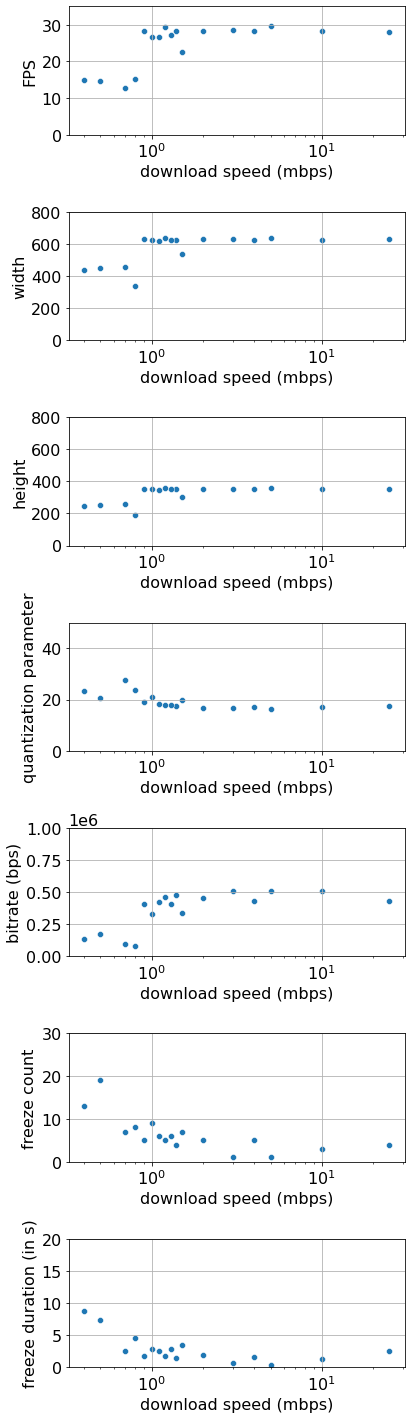

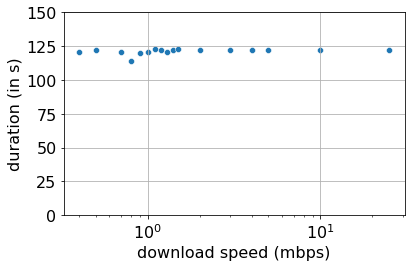

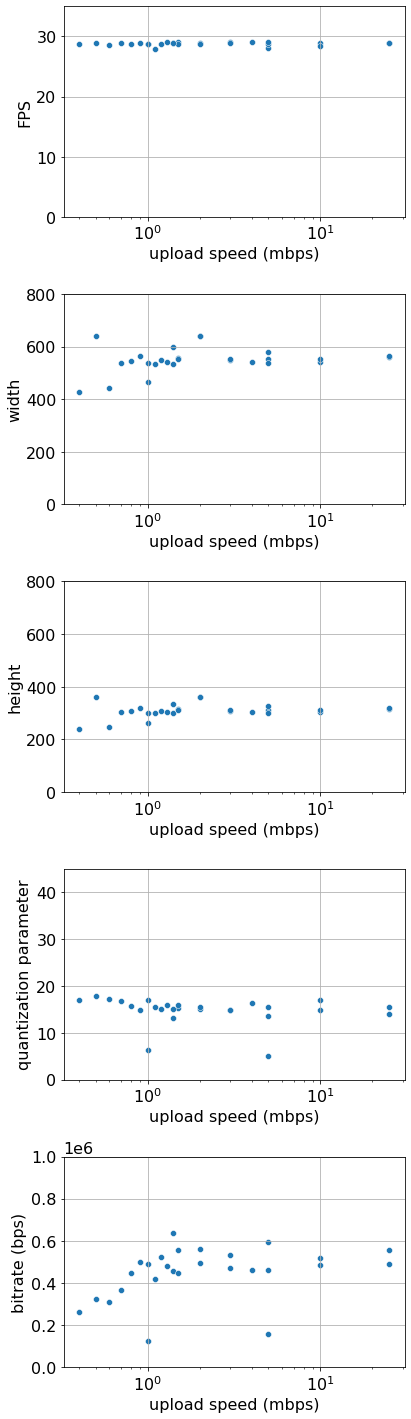

In [270]:
vca = "teams"
in_dir = f"../data/{vca}/webrtc/*.json"
file_list = glob.glob(in_dir)
exp_stat_map = {}
for file_name in file_list:
    qos_map = read_data(file_name)
    if qos_map == {}:
        print(f'skipping {file_name}')
        continue
    exp_stat_map[file_name] = qos_map
    
    
file_list = glob.glob(f"../data/{vca}/webrtc/chrome-120-*-100-0-0*.json")

stat_map = {"received_framesPerSecond": "FPS", "received_frameWidth": "width", 
            "received_frameHeight": "height", "received_[qpSum/framesDecoded]": "quantization parameter", 
            "received_[bytesReceived_in_bits/s]": "bitrate (bps)",
            "received_freezeCount*": "freeze count", "received_totalFreezesDuration*": "freeze duration (in s)"}#, "received_pauseCount*", "received_totalPausesDuration*"]

stat_list = list(stat_map.keys())
fig, axs = plt.subplots(len(stat_list))
fig.set_figheight(20)
for i in range(0, len(stat_list)):
    stat_name = stat_list[i]
    network_level_list = []
    median_stat_list = []
    for fname in file_list:
        if fname not in exp_stat_map:
            continue
        network_level_list.append(float(fname.split('-')[2]))
        if stat_name == "received_totalFreezesDuration*" or stat_name == "received_freezeCount*":
            median_stat_list.append(exp_stat_map[fname][stat_name][-1])
        else:
            median_stat_list.append(np.mean(exp_stat_map[fname][stat_name]))
    sns.scatterplot(x=network_level_list, y=median_stat_list, ax=axs[i])
    axs[i].set_ylabel(f'{stat_map[stat_name]}')
    axs[i].set_xlabel('download speed (mbps)')
    axs[i].set_xscale('log')
    axs[i].grid()
    if stat_name == "received_[bytesReceived_in_bits/s]":
        axs[i].set_ylim([0, 1000000])
    elif stat_name == "received_framesPerSecond":
        axs[i].set_ylim([0, 35])
    elif stat_name == "received_frameWidth":
        axs[i].set_ylim([0, 800])
    elif stat_name == "received_frameHeight":
        axs[i].set_ylim([0, 800])
    elif stat_name == "received_freezeCount*":
        axs[i].set_ylim([0, 30])
    elif stat_name == "received_totalFreezesDuration*":
        axs[i].set_ylim([0, 20])    
    elif stat_name == "received_[qpSum/framesDecoded]":
        axs[i].set_ylim([0, 50])
    #axs[i].set_xlim([0.45, 2.5])
plt.tight_layout()
plt.savefig(f"plots/{vca}_download_shaping.pdf")

fig, axs = plt.subplots(1)
network_level_list = []
median_stat_list = []
for fname in file_list:
    if fname not in exp_stat_map:
        continue
    network_level_list.append(float(fname.split('-')[2]))
    median_stat_list.append(len(exp_stat_map[fname][stat_name]))

sns.scatterplot(x=network_level_list, y=median_stat_list, ax=axs)
axs.set_ylabel(f'duration (in s)')
axs.set_xlabel('download speed (mbps)')
axs.set_xscale('log')
axs.set_ylim([0, 150])
axs.grid()
plt.tight_layout()
plt.savefig(f"plots/{vca}_download_duration.pdf")
    
file_list = glob.glob(f"../data/{vca}/webrtc/chrome-120-100-*-0-0*.json")

stat_map = {"sent_framesPerSecond": "FPS", "sent_frameWidth": "width", 
            "sent_frameHeight": "height", "sent_[qpSum/framesEncoded]": "quantization parameter", 
            "sent_[bytesSent_in_bits/s]": "bitrate (bps)"}#, "received_pauseCount*", "received_totalPausesDuration*"]


stat_list = list(stat_map.keys())
fig, axs = plt.subplots(len(stat_list))
fig.set_figheight(20)

for i in range(0, len(stat_list)):
    stat_name = stat_list[i]
    network_level_list = []
    median_stat_list = []
    for fname in file_list:
        if fname not in exp_stat_map:
            continue
        network_level_list.append(float(fname.split('-')[3]))
        median_stat_list.append(np.mean(exp_stat_map[fname][stat_name]))
    sns.scatterplot(x=network_level_list, y=median_stat_list, ax=axs[i])
    axs[i].set_ylabel(f'{stat_map[stat_name]}')
    axs[i].set_xlabel('upload speed (mbps)')
    axs[i].set_xscale('log')
    axs[i].grid()
    if stat_name == "sent_[bytesSent_in_bits/s]":
        axs[i].set_ylim([0, 1000000])
    elif stat_name == "sent_framesPerSecond":
        axs[i].set_ylim([0, 35])
    elif stat_name == "sent_frameWidth":
        axs[i].set_ylim([0, 800])
    elif stat_name == "sent_frameHeight":
        axs[i].set_ylim([0, 800])
    elif stat_name == "sent_[qpSum/framesEncoded]":
        axs[i].set_ylim([0, 45])
plt.tight_layout()
plt.savefig(f"plots/{vca}_upload_shaping.pdf")

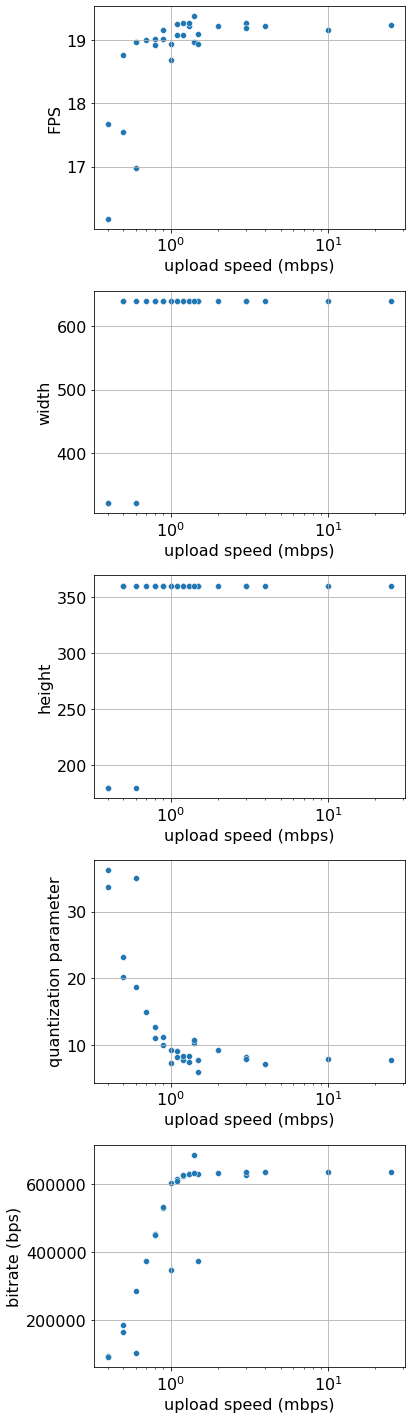

In [ ]:
file_list = glob.glob("../data/webrtc/chrome-120-100-25-*-0*.json")
print(file_list)
stat_map = {"received_framesPerSecond": "r_FPS", "received_frameWidth": "r_width", 
            "received_frameHeight": "r_height", "received_[qpSum/framesDecoded]": "r_quantization parameter", 
            "received_[bytesReceived_in_bits/s]": "r_bitrate (bps)",
            "received_freezeCount*": "r_freeze count", "received_totalFreezesDuration*": "r_freeze duration (in s)", "sent_framesPerSecond": "s_FPS", "sent_frameWidth": "s_width", 
            "sent_frameHeight": "s_height", "sent_[qpSum/framesEncoded]": "s_quantization parameter", 
            "sent_[bytesSent_in_bits/s]": "s_bitrate (bps)"}#, "received_pauseCount*", "received_totalPausesDuration*"]
vca = "meets"

stat_list = list(stat_map.keys())
fig, axs = plt.subplots(len(stat_list))
fig.set_figheight(20)

for i in range(0, len(stat_list)):
    stat_name = stat_list[i]
    network_level_list = []
    median_stat_list = []
    for fname in file_list:
        network_level_list.append(float(fname.split('-')[4]))
        median_stat_list.append(np.median(exp_stat_map[fname][stat_name]))
    sns.scatterplot(x=network_level_list, y=median_stat_list, ax=axs[i])
    axs[i].set_ylabel(f'{stat_map[stat_name]}')
    axs[i].set_xlabel('latency (ms)')
    axs[i].set_xscale('log')
    axs[i].grid()
plt.tight_layout()
plt.savefig(f"plots/{vca}_latency_shaping.pdf")

### meet video 2 

In [ ]:
vca = "meet"
in_dir = f"../data/webrtc_video2/{vca}/*.json"
file_list = glob.glob(in_dir)
exp_stat_map = {}
for file_name in file_list:
    qos_map = read_data(file_name)
    if qos_map == {}:
        print(f'skipping {file_name}')
    exp_stat_map[file_name] = qos_map
    
file_list = glob.glob(f"../data/webrtc_video2/{vca}/chrome-120-*-100-0-0*.json")

stat_map = {"received_framesPerSecond": "FPS", "received_frameWidth": "width", 
            "received_frameHeight": "height", "received_[qpSum/framesDecoded]": "quantization parameter", 
            "received_[bytesReceived_in_bits/s]": "bitrate (bps)",
            "received_freezeCount*": "freeze count", "received_totalFreezesDuration*": "freeze duration (in s)"}#, "received_pauseCount*", "received_totalPausesDuration*"]

stat_list = list(stat_map.keys())
fig, axs = plt.subplots(len(stat_list))
fig.set_figheight(20)
for i in range(0, len(stat_list)):
    stat_name = stat_list[i]
    network_level_list = []
    median_stat_list = []
    for fname in file_list:
        network_level_list.append(float(fname.split('-')[2]))
        median_stat_list.append(np.median(exp_stat_map[fname][stat_name]))
    sns.scatterplot(x=network_level_list, y=median_stat_list, ax=axs[i])
    axs[i].set_ylabel(f'{stat_map[stat_name]}')
    axs[i].set_xlabel('download speed (mbps)')
    axs[i].set_xscale('log')
    axs[i].grid()
    #axs[i].set_xlim([0.45, 2.5])
plt.tight_layout()
plt.savefig(f"plots/{vca}_download_shaping_video2.pdf")

## teams api stats

In [225]:
def get_active_stream(stats, key_list, pref, stat_suff = "[packetsSent/s]"):
    id_map = {}
    for key in key_list:
        key_id = key.split('-')[0].split('_')[-1]
        id_map[key_id] = f'{pref}_{key_id}-{stat_suff}'
    if len(id_map) == 1:
        return list(id_map.keys())[0]
    
    
    for key_id in list(id_map.keys()):
        if id_map[key_id] not in stats:
            id_map.pop(key_id)

    total_count_list = [np.sum(cast_float(stats[id_map[x]]['values'][1:-1].split(','))) for x in id_map]
    if len(total_count_list) == 0:
        return ""
    max_index, max_value = max(enumerate(total_count_list), key=operator.itemgetter(1))
    return list(id_map.keys())[max_index]

def read_data_teams(fname):
    qos_map = {}
    
    ## load the json object
    content = ''.join(list(map(str.strip, open(fname).readlines())))
    json_data = json.loads(content)
    json_stats = json_data["PeerConnections"]
    pc_list = list(json_stats.keys())
    stats = json_stats[pc_list[0]]["stats"]
    stat_key_list = stats.keys()

    
    pref = "RTCInboundRTPVideoStream"
    candidate_keys = find_keys(stat_key_list, pref)
    #print_list(candidate_keys)
    active_stream_id = get_active_stream(stats, candidate_keys, pref, stat_suff = "[packetsReceived/s]")
    
    if active_stream_id == "":
        return {}
    
    stat_name_list = ['frameHeight', 'frameWidth', 'framesPerSecond', "[bytesReceived_in_bits/s]", "[qpSum/framesDecoded]", "pliCount", "firCount"]

    for stat_name in stat_name_list:
        stat_full_name = f'{pref}_{active_stream_id}-{stat_name}'
        qos_map[f'received_{stat_name}'] = cast_float(stats[stat_full_name]['values'][1:-1].split(','))

    ## outbound stats 
    stat_name_list = ['frameHeight', 'frameWidth', 'framesPerSecond', "[bytesSent_in_bits/s]", "[qpSum/framesEncoded]"]


    pref = "RTCOutboundRTPVideoStream"
    candidate_keys = find_keys(stat_key_list, pref)
    active_stream_id = get_active_stream(stats, candidate_keys, pref)
    if active_stream_id == "":
        return {}
    

    for stat_name in stat_name_list:
        stat_full_name = f'{pref}_{active_stream_id}-{stat_name}'
        qos_map[f'sent_{stat_name}'] = cast_float(stats[stat_full_name]['values'][1:-1].split(','))



    stat_name_list = ["jitterBufferDelay", "[jitterBufferDelay/jitterBufferEmittedCount_in_ms]", "freezeCount*", "pauseCount*", "totalFreezesDuration*", "totalPausesDuration*"]    
    pref = "RTCMediaStreamTrack_receiver"
    candidate_keys = find_keys(stat_key_list, pref)
    active_stream_id = get_active_stream(stats, candidate_keys, pref, stat_suff="freezeCount*")
    if active_stream_id == "":
        return {}
    
    for stat_name in stat_name_list:
        stat_full_name = f'{pref}_{active_stream_id}-{stat_name}'
        qos_map[f'received_{stat_name}'] = cast_float(stats[stat_full_name]['values'][1:-1].split(','))

  
    return qos_map    

In [231]:
fname = "../data/teams/webrtc/chrome-120-0.7-100-0-0-1618176399.json"
qos_map = read_data_teams(fname)
print(qos_map.keys())

dict_keys(['received_frameHeight', 'received_frameWidth', 'received_framesPerSecond', 'received_[bytesReceived_in_bits/s]', 'received_[qpSum/framesDecoded]', 'received_pliCount', 'received_firCount', 'sent_frameHeight', 'sent_frameWidth', 'sent_framesPerSecond', 'sent_[bytesSent_in_bits/s]', 'sent_[qpSum/framesEncoded]', 'received_jitterBufferDelay', 'received_[jitterBufferDelay/jitterBufferEmittedCount_in_ms]', 'received_freezeCount*', 'received_pauseCount*', 'received_totalFreezesDuration*', 'received_totalPausesDuration*'])


skipping ../data/teams/webrtc/chrome-120-0.6-100-0-0-1618176607.json


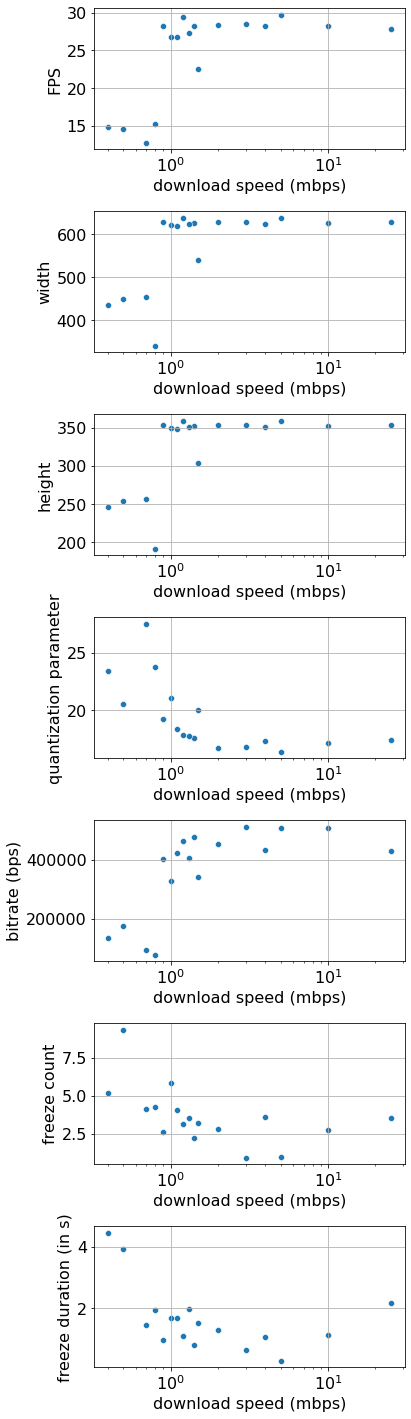

In [235]:
vca = "teams"
in_dir = f"../data/{vca}/webrtc/*.json"
file_list = glob.glob(in_dir)
exp_stat_map = {}
for file_name in file_list:
    qos_map = read_data(file_name)
    if qos_map == {}:
        print(f'skipping {file_name}')
        continue
    exp_stat_map[file_name] = qos_map
    
file_list = glob.glob(f"../data/{vca}/webrtc/chrome-120-*-100-0-0*.json")

stat_map = {"received_framesPerSecond": "FPS", "received_frameWidth": "width", 
            "received_frameHeight": "height", "received_[qpSum/framesDecoded]": "quantization parameter", 
            "received_[bytesReceived_in_bits/s]": "bitrate (bps)",
            "received_freezeCount*": "freeze count", "received_totalFreezesDuration*": "freeze duration (in s)"}#, "received_pauseCount*", "received_totalPausesDuration*"]

stat_list = list(stat_map.keys())
fig, axs = plt.subplots(len(stat_list))
fig.set_figheight(20)
for i in range(0, len(stat_list)):
    stat_name = stat_list[i]
    network_level_list = []
    median_stat_list = []
    for fname in file_list:
        if fname not in exp_stat_map:
            continue
        network_level_list.append(float(fname.split('-')[2]))
        median_stat_list.append(np.mean(exp_stat_map[fname][stat_name]))
    
    sns.scatterplot(x=network_level_list, y=median_stat_list, ax=axs[i])
    axs[i].set_ylabel(f'{stat_map[stat_name]}')
    axs[i].set_xlabel('download speed (mbps)')
    axs[i].set_xscale('log')
    axs[i].grid()
plt.tight_layout()
plt.savefig(f"plots/{vca}_download_shaping.pdf")

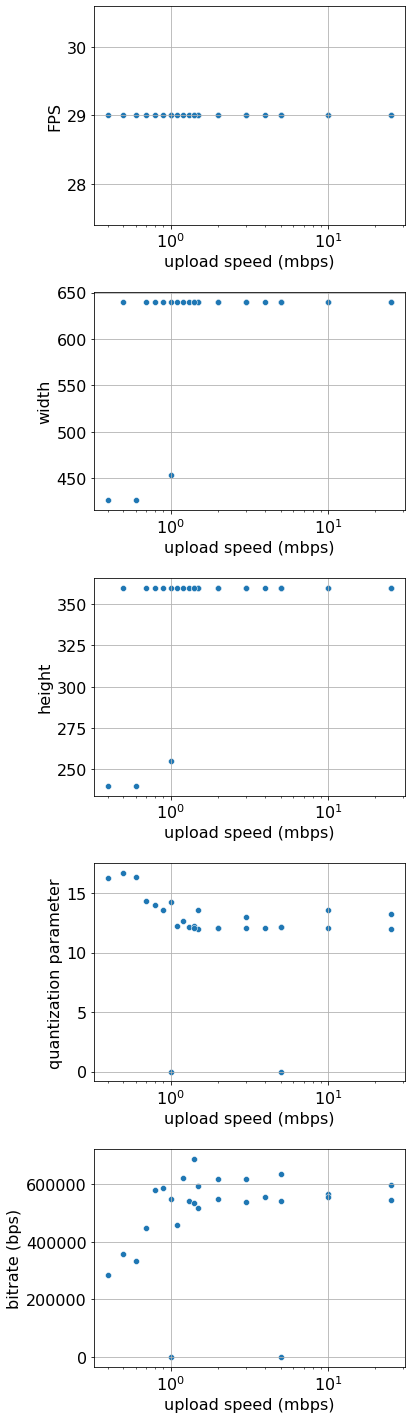

In [238]:
vca = "teams"
file_list = glob.glob(f"../data/{vca}/webrtc/chrome-120-100-*-0-0*.json")

stat_map = {"sent_framesPerSecond": "FPS", "sent_frameWidth": "width", 
            "sent_frameHeight": "height", "sent_[qpSum/framesEncoded]": "quantization parameter", 
            "sent_[bytesSent_in_bits/s]": "bitrate (bps)"}#, "received_pauseCount*", "received_totalPausesDuration*"]



stat_list = list(stat_map.keys())
fig, axs = plt.subplots(len(stat_list))
fig.set_figheight(20)

for i in range(0, len(stat_list)):
    stat_name = stat_list[i]
    network_level_list = []
    median_stat_list = []
    for fname in file_list:
        if fname not in exp_stat_map:
            continue
        network_level_list.append(float(fname.split('-')[3]))
        median_stat_list.append(np.median(exp_stat_map[fname][stat_name]))
    sns.scatterplot(x=network_level_list, y=median_stat_list, ax=axs[i])
    axs[i].set_ylabel(f'{stat_map[stat_name]}')
    axs[i].set_xlabel('upload speed (mbps)')
    axs[i].set_xscale('log')
    axs[i].grid()
plt.tight_layout()
plt.savefig(f"plots/{vca}_upload_shaping.pdf")

## zoom api stats

In [10]:


#print(json_data)

dict_keys(['page_count', 'page_size', 'total_records', 'next_page_token', 'participants'])


In [60]:
file_list = glob.glob("../data/zoom/api/*.json")

import datetime, time, calendar
def get_timestamp(x):
    dt_obj = datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
    return calendar.timegm(dt_obj.timetuple())

def read_network_logs(fname):
    log_list = []
    content = open(fname).readlines()
    for line in content:
        log = list(map(float, line[:-1].split(' ')))
        if len(log) != 6:
            continue
        log_list.append(log)
    return log_list 

def find_nearest(timestamp, log_list):
    diff_list = [abs(x[0]-timestamp) for x in log_list]
    min_index, min_value = min(enumerate(diff_list), key=operator.itemgetter(1))
    return log_list[min_index]

log_list = read_network_logs("../src/run1")

def get_stat(qos_map, pref1, pref2, strip_pref, is_res=None):
    stat_list = [x[pref1][pref2].strip(strip_pref) for x in qos_map]
    stat_list = [x for x in stat_list if len(x) > 0]
    if len(stat_list) == 0:
        return -1
    if is_res == "height":
        height_list = [int(x.split('*')[0]) for x in stat_list]    
        return int(np.mean(height_list))
    elif is_res == "width":
        width_list = [int(x.split('*')[1]) for x in stat_list]
        return int(np.mean(width_list))
    
    else:
        stat_list = [float(x) for x in stat_list]
        return np.mean(stat_list)

qos_stat = {}
for fname in file_list:
    content = open(fname).readline()
    json_data = json.loads(content)

    for call in json_data["participants"]:
        join_time = get_timestamp(call["join_time"])
        end_time = get_timestamp(call["leave_time"])
        call_dur = end_time - join_time
        if end_time - join_time > 150:
            print(call_dur)
            continue
        log = tuple(find_nearest(join_time, log_list))
        diff = join_time-log[0]
        
        qos_stat[log] = {}
        
        qos_map = call['user_qos']
        
        qos_stat[log]['recv_video_bitrate'] = get_stat(qos_map, "video_input", "bitrate", " kbps")
        qos_stat[log]['send_video_bitrate'] = get_stat(qos_map, "video_output", "bitrate", " kbps")
        
        qos_stat[log]['recv_video_res_height'] = get_stat(qos_map, "video_input", "resolution", "", is_res="height")
        qos_stat[log]['recv_video_res_width'] = get_stat(qos_map, "video_input", "resolution", "", is_res="width")
        qos_stat[log]['recv_video_fps'] = get_stat(qos_map, "video_input", "frame_rate", " fps")
        
        qos_stat[log]['recv_latency'] = get_stat(qos_map, "video_input", "latency", " ms")
        qos_stat[log]['send_latency'] = get_stat(qos_map, "video_output", "latency", " ms")

        qos_stat[log]['recv_jitter'] = get_stat(qos_map, "video_input", "jitter", " ms")
        qos_stat[log]['send_jitter'] = get_stat(qos_map, "video_output", "jitter", " ms")

        
        qos_stat[log]['recv_max_loss'] = get_stat(qos_map, "video_input", "max_loss", "%")
        qos_stat[log]['send_max_loss'] = get_stat(qos_map, "video_output", "max_loss", "%")

11347
9050
267
191
156
7297
265
7257


[1.0, 0.9, 0.5, 0.8, 0.7, 0.4, 0.6, 25.0, 4.0, 1.1, 1.2, 10.0, 1.3, 5.0, 3.0, 1.4, 1.5, 2.0] [742.0, 607.3333333333334, 317.0, 544.6666666666666, 443.5, 298.6666666666667, 379.6666666666667, 863.5, 942.5, 748.0, 699.0, 847.6666666666666, 849.5, 724.0, 814.3333333333334, 806.3333333333334, 803.5, 774.0]
[1.0, 0.9, 0.5, 0.8, 0.7, 0.4, 0.6, 25.0, 4.0, 1.1, 1.2, 10.0, 1.3, 5.0, 3.0, 1.4, 1.5, 2.0] [640, 640, 560, 640, 640, 586, 586, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640]
[1.0, 0.9, 0.5, 0.8, 0.7, 0.4, 0.6, 25.0, 4.0, 1.1, 1.2, 10.0, 1.3, 5.0, 3.0, 1.4, 1.5, 2.0] [360, 360, 315, 360, 360, 330, 330, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360]
[1.0, 0.9, 0.5, 0.8, 0.7, 0.4, 0.6, 25.0, 4.0, 1.1, 1.2, 10.0, 1.3, 5.0, 3.0, 1.4, 1.5, 2.0] [24.5, 21.666666666666668, 17.0, 21.0, 18.5, 16.666666666666668, 19.666666666666668, 26.0, 25.5, 22.0, 22.5, 25.666666666666668, 24.5, 22.666666666666668, 25.0, 25.333333333333332, 25.0, 21.0]
[1.0, 0.9, 0.5, 0.8, 0.7, 0.4, 0.6, 25.0, 

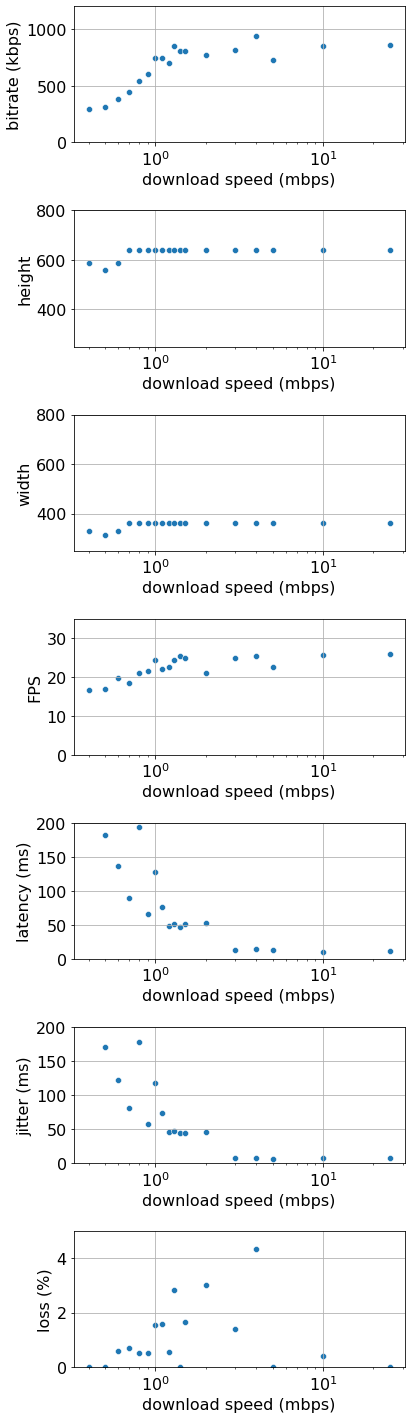

In [74]:
def plot_download_zoom(qos_stat_map):
    stat_list = ["recv_video_bitrate", "recv_video_res_height", "recv_video_res_width", "recv_video_fps", "recv_latency", "recv_jitter", "recv_max_loss"]    
    stat_map = {"recv_video_bitrate": "bitrate (kbps)", "recv_video_res_height": "height", "recv_video_res_width": "width",
                "recv_video_fps": "FPS" , "recv_latency": "latency (ms)", "recv_jitter": "jitter (ms)", 
                "recv_max_loss": "loss (%)"}  
    fig, axs = plt.subplots(len(stat_list))
    fig.set_figheight(20)
    for i in range(0, len(stat_list)):
        stat_name = stat_list[i]
        network_level_list = []
        stat_val_list = []
        for k in qos_stat_map:
            if k[3] != 100 or k[4] != 0 or k[5]!= 0:
                continue
            downlink_bw = k[2]
            stat_val_list.append(qos_stat_map[k][stat_name])
            network_level_list.append(downlink_bw)
        print(network_level_list, stat_val_list)
        sns.scatterplot(x=network_level_list, y=stat_val_list, ax=axs[i])
        axs[i].set_ylabel(f'{stat_map[stat_name]}')
        axs[i].set_xlabel('download speed (mbps)')
        axs[i].set_xscale('log')
        axs[i].grid()
        if stat_name == "recv_video_bitrate":
            axs[i].set_ylim([0, 1200])
        elif stat_name == "recv_video_res_height":
            axs[i].set_ylim([250, 800])
        elif stat_name == "recv_video_res_width":
            axs[i].set_ylim([250, 800])
        elif stat_name == "recv_video_fps":
            axs[i].set_ylim([0, 35])
        elif stat_name == "recv_latency":
            axs[i].set_ylim([0, 200])
        elif stat_name == "recv_jitter":
            axs[i].set_ylim([0, 200])
        elif stat_name == "recv_max_loss":
            axs[i].set_ylim([0, 5])
    plt.tight_layout()
    plt.savefig(f"plots/zoom_download_shaping.pdf")  

plot_download_zoom(qos_stat)

[25.0, 1.1, 0.4, 0.7, 0.9, 0.8, 0.6, 0.5, 1.0, 1.2, 1.4, 3.0, 2.0, 1.3, 10.0, 5.0, 25.0, 4.0, 1.5] [647.6666666666666, 708.3333333333334, 196.0, 449.0, 628.5, 541.6666666666666, 365.0, 272.3333333333333, 618.6666666666666, 766.5, 875.3333333333334, 888.0, 739.0, 719.6666666666666, 796.0, 750.0, 696.0, 774.0, 873.5]
[25.0, 1.1, 0.4, 0.7, 0.9, 0.8, 0.6, 0.5, 1.0, 1.2, 1.4, 3.0, 2.0, 1.3, 10.0, 5.0, 25.0, 4.0, 1.5] [0.0, 64.33333333333333, 186.0, 150.66666666666666, 91.5, 69.0, 107.0, 76.0, 99.0, 67.0, 34.0, 17.0, 36.333333333333336, 76.0, 18.0, 18.666666666666668, 0.0, 17.0, 37.0]
[25.0, 1.1, 0.4, 0.7, 0.9, 0.8, 0.6, 0.5, 1.0, 1.2, 1.4, 3.0, 2.0, 1.3, 10.0, 5.0, 25.0, 4.0, 1.5] [4.666666666666667, 57.333333333333336, 147.33333333333334, 109.66666666666667, 86.5, 61.333333333333336, 90.5, 62.333333333333336, 93.33333333333333, 58.0, 26.333333333333332, 12.0, 32.333333333333336, 67.33333333333333, 11.666666666666666, 12.0, 11.0, 12.0, 30.5]
[25.0, 1.1, 0.4, 0.7, 0.9, 0.8, 0.6, 0.5, 1.0, 1.

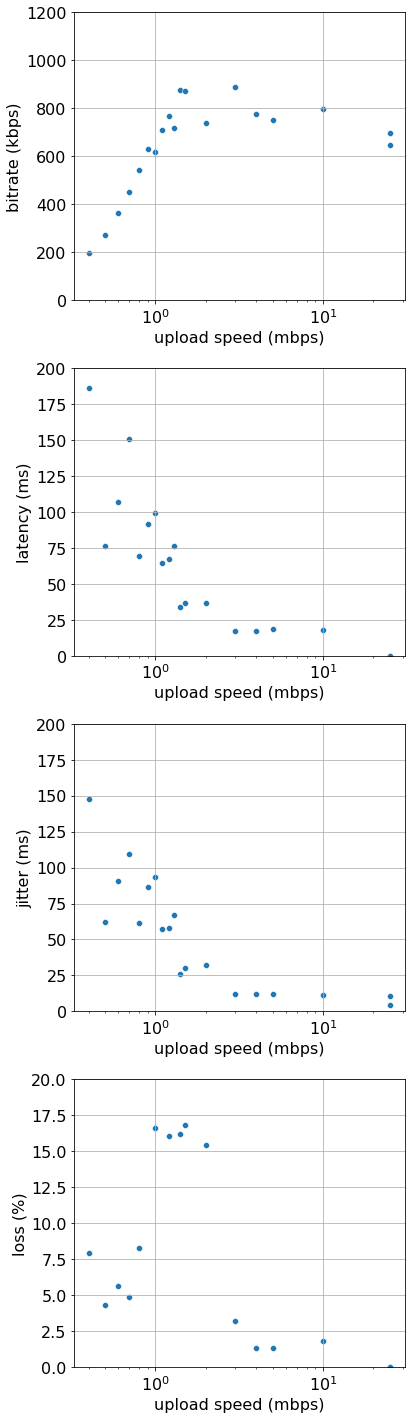

In [73]:
def plot_upload_zoom(qos_stat_map):
    stat_list = ["send_video_bitrate", "send_latency", "send_jitter", "send_max_loss"]    
    stat_map = {"send_video_bitrate": "bitrate (kbps)" , "send_latency": "latency (ms)", "send_jitter": "jitter (ms)", 
                "send_max_loss": "loss (%)"}  
    fig, axs = plt.subplots(len(stat_list))
    fig.set_figheight(20)
    for i in range(0, len(stat_list)):
        stat_name = stat_list[i]
        network_level_list = []
        stat_val_list = []
        for k in qos_stat_map:
            if k[2] != 100 or k[4] != 0 or k[5]!= 0:
                continue
            uplink_bw = k[3]
            stat_val_list.append(qos_stat_map[k][stat_name])
            network_level_list.append(uplink_bw)
        print(network_level_list, stat_val_list)
        sns.scatterplot(x=network_level_list, y=stat_val_list, ax=axs[i])
        axs[i].set_ylabel(f'{stat_map[stat_name]}')
        axs[i].set_xlabel('upload speed (mbps)')
        axs[i].set_xscale('log')
        axs[i].grid()
        if stat_name == "send_video_bitrate":
            axs[i].set_ylim([0, 1200])
        elif stat_name == "send_latency":
            axs[i].set_ylim([0, 200])
        elif stat_name == "send_jitter":
            axs[i].set_ylim([0, 200])
        elif stat_name == "send_max_loss":
            axs[i].set_ylim([0, 20])
    plt.tight_layout()
    plt.savefig(f"plots/zoom_upload_shaping.pdf")  

plot_upload_zoom(qos_stat)